# Lecture 4: Matvec complexity, FFT, fast convolution

## Matrix-by-vector multiplication (matvec)

Multiplication of matrix $A$ of size $n\times n$ by vector $x$ of size $n\times 1$:
$$
y_{i} = \sum_{i=1}^n a_{ij} x_j
$$
requires $n^2$ mutliplications and $n(n-1)$ additions. Thus, the overall complexity is $2n^2 - n =$ <font color='red'> $\mathcal{O}(n^2)$ </font>.

## How bad is $\mathcal{O}(n^2)$

To understand how time-consuming $\mathcal{O}(n^2)$ can be consider the following example.
Let $A$ be the matrix of pairwise gravitational interaction between planets in a galaxy.
The number of planets in an average galaxy is $10^{11}$, so the size of this matrix will be $10^{11} \times 10^{11}$.
To model evolution in time we have to multiply this matrix by vector at each time step.
Top supercomputers do around $10^{16}$ floating point operations per second (flops), so the time to multiply matrix $A$ by vector will take approximately
$$
\frac{(10^{11})^2 \text{ operations}}{10^{16} \text{ flops}} = 10^6 \text{ sec} \approx 11.5 \text{ days} 
$$
for one time step. If we could multiply it with $\mathcal{O}(n)$ complexity, we would get
$$
\frac{10^{11} \text{ operations}}{10^{16} \text{ flops}} = 10^{-5} \text{ sec}
$$
instead. Fortunately, there is an algorithm to be $\mathcal{O}(n)$ for this particular example.

Here is the YouTube video that illustrates collision of two galaxisies which was modelled by $\mathcal{O}(n)$ (or maybe $\mathcal{O}(n \log n)$) algorithm:

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("7HF5Oy8IMoM")

The question is can we be asymptotically faster for general matrix $A$?

## Can we beat $\mathcal{O}(n^2)$?

Generally speaking no. The point is that we have $\mathcal{O}(n^2)$ input data, so there is no way to be faster for general matrix.
Fortunately, we can be faster <font color='red'>for certain types of matrices</font>.
Here are some examples:

* The simplest example may be matrix of all ones, which can be easily multiplied with only $n-1$ additions. This matrix is of rank one. More generally we can multiply fast by <font color='red'>low-rank </font> matrices (or that have low-rank blocks)

* <font color='red'>Sparse</font> matrices (contain $\mathcal{O}(n)$ nonzero elements)

* <font color='red'>Structured</font> matrices (later this lecture):
  * Fourier
  * Circulant
  * Toeplitz 
  * Hankel

## Fourier matrix

The Fourier matrix is defined as:
$$
    F_n =
        \begin{pmatrix}
            1 & 1 & 1 & \dots & 1 \\
            1 & w^{1\cdot 1}_n & w^{1\cdot 2}_n & \dots & w^{1\cdot (n-1)}_n\\
            1 & w^{2\cdot 1}_n & w^{2\cdot 2}_n & \dots & w^{2\cdot (n-1)}_n\\
            \dots & \dots & \dots &\dots &\dots \\
            1 & w^{(n-1)\cdot 1}_n & w^{(n-1)\cdot 2}_n & \dots & w^{(n-1)\cdot (n-1)}_n\\
        \end{pmatrix},
$$
or equivalently
$$
    F_n = \{ w_n^{kl} \}_{k,l=0}^{n-1},
$$
where $$w_n = e^{-\frac{2\pi i}{n}}.$$

**Properties:**
* Symmetric (not Hermitian!)
* Unitary up to the scaling factor: $F_n^* F_n = F_n F_n^* = nI$ (check this fact). Therefore $F_n^{-1} = \frac{1}{n}F^*_n$
* Can be multiplied by vector (called dicrete Fourier transform or DFT) with <font color='red'>$\mathcal{O}(n \log n)$</font> complexity (called fast Fourier transform or <font color='red'>FFT</font>)! FFT helps to analyze spectrum of a signal and, as we will see further, helps to do fast mutiplications with certain types of matrices.

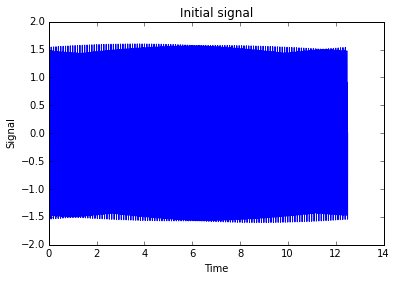

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


N = 10000
dt = 1.0 / 800.0
x = np.linspace(0.0, N*dt, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.2*np.sin(300.0 * 2.0*np.pi*x)
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Initial signal')

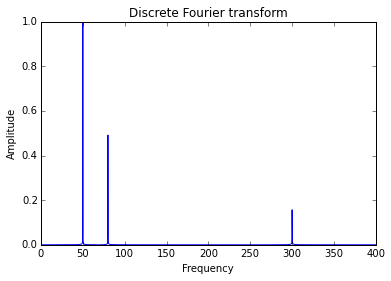

In [5]:
yf = np.fft.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*dt), N/2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N/2])) #Note: N/2 to N will give negative frequencies
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Discrete Fourier transform')

## Fast Fourier transform (FFT)
Here we consider matrix interpretation of standard Cooley-Tukey algorithm (1965), which has underlying **divide and conquerer** idea. Note that in packages more advanced vesions are used.

Let $n$ be a power of 2. First of all we <font color='red'>permute rows</font> of the Fourier matrix such that first $n/2$ rows of the new matrix had row numbers <font color='red'>$1,3,5,\dots,n-1$</font> and last $n/2$ rows had row numbers <font color='red'>$2,4,6\dots,n$</font>. 
This permutation can be expressed in terms of multiplication by permutation matrix $P_n$:
$$
P_n =
        \begin{pmatrix}
           1 & 0 & 0 & 0 & \dots & 0 & 0 \\
           0 & 0 & 1 & 0 &\dots & 0 & 0 \\
           \vdots & & & & & & \vdots \\
           0 & 0 & 0 & 0 &\dots & 1 & 0 \\
           \hline
           0 & 1 & 0 & 0 & \dots & 0 & 0 \\
           0 & 0 & 0 & 1 &\dots & 0 & 0 \\
           \vdots & & & & & & \vdots \\
           0 & 0 & 0 & 0 &\dots & 0 & 1 
        \end{pmatrix},
$$

Hence,
$$
P_n F_n =
        \begin{pmatrix}
            1 & 1 & 1 & \dots & 1 \\
            1 & w^{2\cdot 1}_n & w^{2\cdot 2}_n & \dots & w^{2\cdot (n-1)}_n\\
            1 & w^{4\cdot 1}_n & w^{4\cdot 2}_n & \dots & w^{4\cdot (n-1)}_n\\
            \vdots & & & & \vdots\\
            1 & w^{(n-2)\cdot 1}_n & w^{(n-2)\cdot 2}_n & \dots & w^{(n-2)\cdot (n-1)}_n\\
            \hline
            1 & w^{1\cdot 1}_n & w^{1\cdot 2}_n & \dots & w^{1\cdot (n-1)}_n\\
            1 & w^{3\cdot 1}_n & w^{3\cdot 2}_n & \dots & w^{3\cdot (n-1)}_n\\           
            \vdots & & & & \vdots\\
            1 & w^{(n-1)\cdot 1}_n & w^{(n-1)\cdot 2}_n & \dots & w^{(n-1)\cdot (n-1)}_n\\
        \end{pmatrix},
$$
Now let us imagine that we separated its columns and rows by two parts each of size $n/2$.

As a result we get <font color='red'>$2\times 2$ block matrix</font> that has the following form
$$
P_n F_n =
    \begin{pmatrix}
    \left\{w^{2kl}_n\right\} & \left\{w_n^{2k\left(\frac{n}{2} + l\right)}\right\} \\
    \left\{w_n^{(2k+1)l}\right\} & \left\{w_n^{(2k+1)\left(\frac{n}{2} + l\right)}\right\}
    \end{pmatrix},
\quad k,l = 0,\dots, \frac{n}{2}-1.
$$
So far it does not look like something that works faster :) But we will see that in a minute.
Lets have a more precise look at the first block $\left\{w^{2kl}_n\right\}$:
$$
w^{2kl}_n = e^{-2kl\frac{2\pi i}{n}} = e^{-kl\frac{2\pi i}{n/2}} = w^{kl}_{n/2}.
$$
So this block is exactly twice smaller Fourier matrix $F_{n/2}$!

<!---
Now we can write
$$
\begin{pmatrix}
    F_{n/2} & \left\{w_n^{2k\left(\frac{n}{2} + l\right)}\right\} \\
    \left\{w_n^{(2k+1)l}\right\} & \left\{w_n^{(2k+1)\left(\frac{n}{2} + l\right)}\right\}
\end{pmatrix}
$$
-->
The block $\left\{w_n^{(2k+1)l}\right\}$ can be written as
$$
w_n^{(2k+1)l} = w_n^{2kl + l} = w_n^{l} w_n^{2kl} = w_n^{l} w_{n/2}^{kl},
$$
which can be written as $W_{n/2}F_{n/2}$, where $$W_{n/2} = \text{diag}(1,w_n,w_n^2,\dots,w_n^{n/2-1}).$$

Doing same tricks for other blocks we will finally get
$$
P_n F_n =
\begin{pmatrix}
    F_{n/2} & F_{n/2} \\
    F_{n/2}W_{n/2} & -F_{n/2}W_{n/2}
\end{pmatrix}
=
\begin{pmatrix}
    F_{n/2} & 0 \\
    0 & F_{n/2}
\end{pmatrix}
\begin{pmatrix}
    I_{n/2} & I_{n/2} \\
    W_{n/2} & -W_{n/2}
\end{pmatrix}.
$$
Thus, we <font color='red'>reduced multiplication by $F_n$ to 2 multiplications by $F_{n/2}$</font> and cheap multiplications by diagonal matrices. If we apply obtained expressions recursively to $F_{n/2}$, we will get $\mathcal{O}(n\log n)$ complexity.

In [6]:
#FFT vs full matvec
import time
import numpy as np
import scipy as sp
import scipy.linalg

n = 10000
F = sp.linalg.dft(n)
x = np.random.randn(n)

t = time.time()
y_full = F.dot(x)
print 'Full matvec time =', time.time() - t

t = time.time()
y_fft = np.fft.fft(x)
print 'FFT time =', time.time() - t

print 'Relative error =', (np.linalg.norm(y_full - y_fft)) / np.linalg.norm(y_full)

Full matvec time = 0.193336009979
FFT time = 0.000387907028198
Relative error = 1.52703187922e-12


## Circulant matrices



FFT helps to multiply fast by certain types of matrices. We start from circulant matrix:

$$
C =
\begin{pmatrix} 
    c_0 & c_{n-1} & c_{n-2} & \dots & c_1 \\
    c_{1} & c_{0} & c_{n-1} & \dots & c_2 \\
    c_{2} & c_{1} & c_0 & \dots & c_3 \\
    \dots & \dots & \dots & \dots & \dots \\
    c_{n-1} & c_{n-2} & c_{n-3} & \dots & c_0
\end{pmatrix}
$$

**Theorem.** 
Let $C$ be a circulant matrix of size $n\times n$ with first column $c$, then
$$
    C = \frac{1}{n} F_n^* \text{diag}(F_n c) F_n 
$$

*Proof.* 
Consider a number $$\lambda (\omega) = c_0 + \omega c_1 + \dots + \omega^{n-1} c_{n-1},$$ where $\omega$ is any number such that $\omega^n=1$. Lets multiply $\lambda$ by $1,\omega,\dots, \omega^{n-1}$:
$$
\begin{split}
\lambda & = c_0 &+& \omega c_1 &+& \dots &+& \omega^{n-1} c_{n-1},\\
\lambda\omega & = c_{n-1} &+& \omega c_0 &+& \dots &+& \omega^{n-1} c_{n-2},\\
\lambda\omega^2 & = c_{n-2} &+& \omega c_{n-1} &+& \dots &+& \omega^{n-1} c_{n-3},\\
&\dots\\
\lambda\omega^{n-1} & = c_{1} &+& \omega c_{2} &+& \dots &+& \omega^{n-1} c_{0}.
\end{split}
$$
Therefore,
$$
\lambda(\omega) \cdot \begin{pmatrix} 1&\omega & \dots& \omega^{n-1} \end{pmatrix}
=
\begin{pmatrix} 1&\omega&\dots& \omega^{n-1} \end{pmatrix} \cdot C.
$$
Writing this for $\omega = 1,w_n, \dots, w_n^{n-1}$ we get
$$
\Lambda F_n = F_n C
$$
and finally
$$
C = \frac{1}{n} F^*_n \Lambda F_n, \quad \text{where}\quad \Lambda = \text{diag}(F_nc) \qquad\blacksquare
$$

#### Fast matvec with circulant matrix

Representation $C = \frac{1}{n} F^* \text{diag}(F_n c) F_n $ gives us explicit way to multiply a vector $x$ by $C$ in $\mathcal{O}(n\log n)$ operations. Indeed,
$$
Cx = \frac{1}{n} F_n^* \text{diag}(F_n c) F_n x = \text{ifft}\left( \text{fft}(c) \circ \text{fft}(x)\right)
$$
where $\circ$ denotes elementwise product (Hadamard product) of two vectors (since $\text{diag}(a)b = a\circ b$) and ifft denotes inverse Fourier transform $F^{-1}_n$.

In [ ]:
import time
import numpy as np
import scipy as sp
import scipy.linalg

def circulant_matvec(c, x):
    return np.fft.ifft(np.fft.fft(c) * np.fft.fft(x))

n = 10000
c = np.random.random(n)
C = sp.linalg.circulant(c)
x = np.random.randn(n)

t = time.time()
y_full = C.dot(x)
print 'Full matvec time =', time.time() - t

t = time.time()
y_fft = circulant_matvec(c, x)
print 'FFT time =', time.time() - t

print 'Relative error =', (np.linalg.norm(y_full - y_fft)) / np.linalg.norm(y_full)

## Toeplitz matrices

Another example where FFT can help us with the fast matvec operation are Toeplitz matrices (diagonal constant matrices):
$$
T =
\begin{pmatrix} 
    t_0 & t_{-1} & t_{-2} & t_{-3}& \dots & t_{1-n} \\
    t_{1} & t_{0} & t_{-1} & t_{-2}& \dots & t_{2-n} \\
    t_{2} & t_{1} & t_0 & t_{-1} &\dots & t_{3-n} \\
    t_{3} & t_{2} & t_1 & t_0 & \dots & t_{4-n} \\
    \dots & \dots & \dots & \dots & \dots & \dots\\
    t_{n-1} & t_{n-2} & t_{n-3} & t_{n-4} &\dots &t_0
\end{pmatrix},
$$
or equivalently $T_{ij} = t_{i-j}$.

Matvec operation can be written as
$$
y_i = \sum_{j=1}^n t_{i-j} x_j,
$$
which can be interpreted as a discrete <font color='red'>convolution</font> of filter $t_i$ and signal $x_i$. 
For simplicity the size of the filter $t$ is such that the size of input and output signals are equal. Generally, filter size can be arbitrary.

Fast convolution computation has a variety of applications, for instance, in signal processing or partial differential and integral equations. For instance, here is the smoothing of a signal:

In [ ]:
from scipy import signal
alpha = 0.01
sig = np.repeat([0., 1., 0.], 100)
filt = np.exp(-alpha * (np.arange(100)-50)**2)
filtered = signal.convolve(sig, filt, mode='same') / sum(filt)

fig, (ax_orig, ax_filt, ax_filtered) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.margins(0, 0.1)
ax_filt.plot(filt)
ax_filt.margins(0, 0.1)
ax_filtered.plot(filtered)
ax_filtered.margins(0, 0.1)

ax_orig.set_title('Original signal')
ax_filt.set_title('Filter')
ax_filtered.set_title('Convolution')

fig.tight_layout()

#### Fast matvec with Toeplitz matrix

The multiplication by Toeplitz matrix can be reduced to the multiplication by a circulant.
Indeed, every Toeplitz matrix of size $n\times n$ can be embedded into a Circulant matrix $C$ of size $2n-1 \times 2n-1$:
$$
C = 
\begin{pmatrix}
    T & \dots \\
    \dots & \dots
\end{pmatrix}.
$$
The $3\times 3$ matrix $T = \begin{pmatrix} 
    t_0 & t_{-1} & t_{-2} \\
    t_{1} & t_{0} & t_{-1} \\
    t_{2} & t_{1} & t_0 \\
\end{pmatrix}$ 
can be embedded as follows
$$
C = 
 \begin{pmatrix} 
    t_0 & t_{-1} & t_{-2} & t_{2} & t_{1}\\
    t_{1} & t_{0} & t_{-1} & t_{-2} & t_{2} \\
    t_{2} & t_{1} & t_0 & t_{-1} & t_{-2} \\
    t_{-2}& t_{2} & t_{1} & t_0 & t_{-1}  \\
    t_{-1} & t_{-2} & t_{2} & t_{1} & t_0  
\end{pmatrix}.
$$
For matvec 
$
\begin{pmatrix} y_1 \\ y_2 \\ y_3 \end{pmatrix}
=
\begin{pmatrix} 
    t_0 & t_{-1} & t_{-2} \\
    t_{1} & t_{0} & t_{-1} \\
    t_{2} & t_{1} & t_0 \\
\end{pmatrix}
\begin{pmatrix} x_1 \\ x_2 \\ x_3 \end{pmatrix}
$
we pad vector $x$ with zeros:
$$
\begin{pmatrix} y_1 \\ y_2 \\ y_3 \\ * \\ * \end{pmatrix}
=
\begin{pmatrix} 
    t_0 & t_{-1} & t_{-2} & t_{2} & t_{1}\\
    t_{1} & t_{0} & t_{-1} & t_{-2} & t_{2} \\
    t_{2} & t_{1} & t_0 & t_{-1} & t_{-2} \\
    t_{-2}& t_{2} & t_{1} & t_0 & t_{-1}  \\
    t_{-1} & t_{-2} & t_{2} & t_{1} & t_0  
\end{pmatrix}
\begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ 0 \\ 0 \end{pmatrix}
=
\text{ifft}(
\text{fft}(\begin{pmatrix} t_0 \\ t_{1} \\ t_{2} \\ t_{-2} \\ t_{-1} \end{pmatrix})
\circ
\text{fft}(\begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ 0 \\ 0 \end{pmatrix})
).
$$
Note that you do not need to form and store the whole matrix $T$.

## Multilevel Toeplitz matrices

The 2-dimensional convolution is defined as 
$$
y_{i_1i_2} = \sum_{j_1,j_2=1}^n t_{i_1-j_1, i_2-j_2} x_{j_1 j_2}.
$$
Note that $x$ and $y$ are 2-dimensional arrays and $T$ is 4-dimensional. 
To reduce this expression to matrix-by-vector product we have to reshape $x$ and $y$ into long vectors:
$$
\text{vec}(x) = 
\begin{pmatrix}
    x_{11} \\ \vdots \\ x_{1n} \\ \hline \\ \vdots \\ \hline \\ x_{n1} \\ \vdots \\ x_{nn}
\end{pmatrix},
\quad
\text{vec}(y) = 
\begin{pmatrix}
    y_{11} \\ \vdots \\ y_{1n} \\ \hline \\ \vdots \\ \hline \\ y_{n1} \\ \vdots \\ y_{nn}
\end{pmatrix}.
$$
In this case matrix $T$ is block Toeplitz with Toeplitz blocks:
$$
T = 
\begin{pmatrix} 
    T_0 & T_{-1} & T_{-2} &  \dots & T_{1-n} \\
    T_{1} & T_{0} & T_{-1} & \dots & T_{2-n} \\
    T_{2} & T_{1} & T_0 & \dots & T_{3-n} \\
    \dots & \dots & \dots &  \dots & \dots\\
    T_{n-1} & T_{n-2} & T_{n-3}  &\dots &T_0
\end{pmatrix},
\quad \text{where} \quad
T_k = t_{k, i_2 - j_2}\quad  \text{are Toeplitz matrices}
$$

#### Fast matvec with multilevel Toeplitz matrix

To get fast matvec we need to embed block Toeplitz matrix with Toeplitz blocks into the block circulant matrix with circulant blocks. The analog of
$$
\begin{pmatrix} y_1 \\ y_2 \\ y_3 \\ * \\ * \end{pmatrix}
=
\text{ifft}(
\text{fft}(\begin{pmatrix} t_0 \\ t_{1} \\ t_{2} \\ t_{-2} \\ t_{-1} \end{pmatrix})
\circ
\text{fft}(\begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ 0 \\ 0 \end{pmatrix})
).
$$
will look like
$$
\begin{pmatrix}
    y_{11} & y_{12} & y_{13} & * & *\\ 
    y_{21} & y_{22} & y_{23} & * & *\\  
    y_{31} & y_{32} & y_{33} & * & *\\ 
    * & * & * & * & *\\  
    * & * & * & * & *\\  
\end{pmatrix}
=
\text{ifft2d}(
\text{fft2d}(\begin{pmatrix}
    t_{0,0} & t_{1,0} & t_{2,0} & t_{-2,0} & t_{-1,0}\\ 
    t_{0,1} & t_{1,1} & t_{2,1} & t_{-2,1} & t_{-1,1}\\  
    t_{0,2} & t_{1,2} & t_{2,2} & t_{-2,2} & t_{-1,2}\\ 
    t_{0,-2} & t_{1,-2} & t_{2,-2} & t_{-2,-2} & t_{-1,-2}\\ 
    t_{0,-1} & t_{1,-1} & t_{2,-1} & t_{-2,-1} & t_{-1,-1}
\end{pmatrix})
\circ
\text{fft2d}(\begin{pmatrix}
    x_{11} & x_{12} & x_{13} & 0 & 0\\ 
    x_{21} & x_{22} & x_{23} & 0 & 0\\  
    x_{31} & x_{32} & x_{33} & 0 & 0\\ 
    0 & 0 & 0 & 0 & 0\\  
    0 & 0 & 0 & 0 & 0\\  
\end{pmatrix})
),
$$
where fft2d is 2-dimensional fft that consists of one-dimensional transforms, applied first to rows and and then to columns (or vice versa).

In [ ]:
# Blurring and Sharpening the Lena by convolution

from scipy import signal
from scipy import misc

filter_size = 3
filter_blur = np.ones((filter_size, filter_size)) / filter_size**2
lena = misc.lena()

blurred = signal.convolve2d(lena, filter_blur, boundary='symm', mode='same')

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(lena[200:300, 200:300], cmap='gray')
ax[0, 0].set_title('Original Lena')
ax[0, 1].imshow(blurred[200:300, 200:300], cmap='gray')
ax[0, 1].set_title('Blurred Lena')
ax[1, 0].imshow((lena - blurred)[200:300, 200:300], cmap='gray')
ax[1, 0].set_title('Lena $-$ Blurred Lena')
ax[1, 1].imshow(((lena - blurred)*3 + blurred)[200:300, 200:300], cmap='gray')
ax[1, 1].set_title('$3\cdot$(Lena $-$ Blurred Lena) + Blurred Lena')
fig.tight_layout()

## Conclusions

* For big matrices $\mathcal{O}(n^2)$ is very time-consuming
* Can be better for special types of matrices